### Packages and Function Definitoins

In [620]:
# Loading neccesary packages
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import theano
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import seaborn as sns

In [644]:
# Functions and utilities
def WS_potential(r, V0 = 50, a = 0.5, r0 = 1.25, A = 64):
    R = r0 * A ** (1 / 3)
    V_r = - V0 / (1 + np.exp((r - R) / a))
    return V_r

def C_potential(r, V0 = 50):
    return - V0 / r

def exp_data(r, sd, V0 = 50, a = 0.5, r0 = 1.25, A = 64):
    exp = WS_potential(r, V0, a, r0, A) * 0.5 + C_potential(r, V0) * 0.5 + sd * np.random.randn(len(r))
    return exp

def r_exp(n_exp = 50, r_range = [0.1, 10], domain_type = 1):
    
    if domain_type == 1:
        r = np.random.uniform(low = r_range[0], high = r_range[1], size =  n_exp)
    if domain_type == 2:
        r_1 = np.random.uniform(low = r_range[0] + 3, high = r_range[1], size =  int(n_exp / 2))
        r_2 = np.random.uniform(low = r_range[0], high = r_range[0] + 3, size =  int(n_exp / 2))
        r = np.concatenate((r_2,r_1), axis = 0)
        
    return r

def exp_model(r, y_exp, priors, model_type, V0 = 50, a = 0.5, r0 = 1.25, A = 64):
    
    with pm.Model() as pm_model:

        # priors
        sigma = pm.InverseGamma("sigma", alpha = priors["sigma"][0], beta = priors["sigma"][1], transform=None)

        # covariance
        cov = pm.gp.cov.WhiteNoise(sigma)
        K = cov(r[:, None])

        # mean
        if model_type == "WS":
            m = WS_potential(r, V0, a, r0, A)
        if model_type == "C":
            m = C_potential(r, V0)

        # observations
        obs = pm.MvNormal('obs', mu = m, cov = K, observed = y_exp, transform=None)

    logp = obs.logp
    return pm_model, obs, logp

def evidence_int(priors, pm_model, obs, logp, n_mc):
    
    # evidence integral
    with pm.Model() as priors_model:
        # priors
        sigma = pm.InverseGamma("sigma", alpha = priors["sigma"][0], beta = priors["sigma"][1], transform=None)
        trace_priors = pm.sample(n_mc, tune = 5000, chains = 1)
    plt.hist(trace_priors["sigma"][trace_priors["sigma"] < 100])
    plt.show()
    
    log_likelihood = np.empty(0)
    mc_integral = np.empty(n_mc)
    for i in tqdm(range(n_mc), desc = "Log likelihood eval"):
        log_likelihood = np.append(log_likelihood, logp(trace_priors[i], transfrom = None))

    for i in tqdm(range(n_mc), desc = "Integral calc"):
        m = max(log_likelihood[:(i + 1)])
        mc_integral[i] = (np.exp(m) * np.sum(np.exp(log_likelihood[:(i + 1)] - m))) / (i + 1)
    plt.plot(mc_integral)
    plt.show()
    return mc_integral

def sample_predictions(r_new,  pm_model, obs, model_type, n_pred, V0 = 50, a = 0.5, r0 = 1.25, A = 64):
    with pm_model:
        trace = pm.sample(n_pred, tune = 5000, chains = 1) 
        
    posterior_predictive = np.empty((len(r_new), 1))
    for sigma in tqdm(trace["sigma"], desc = "Posterior predictive distribution"):
        # Covariance
        cov = np.identity(len(r_new)) * sigma
        # Mean
        if model_type == "WS":
            mean = WS_potential(r_new, V0, a, r0, A)
        if model_type == "C":
            mean = C_potential(r_new, V0)
        # Sample from predictive distribution
        sample = np.random.multivariate_normal(mean, cov)[:,None]
        posterior_predictive = np.concatenate((posterior_predictive, sample), axis = 1)
            
    return posterior_predictive[:,1:], trace

def sample_mixture(sample_M1, sample_M2, M1_to_M2_ratio):
    """Function sampel from the mixture under models M1 and M2 according to the provided ratio.
    
    Where:
    sample_M1 - sample from the distribution under M1
    sample_M2 - sample from the distribution under M2
    M1_to_M2_ratio - Ration of the samples for M1 in favor of M2
    """           

    i = 0
    j = 0
    mixture_sample = np.empty((sample_M1.shape[0], 1))
    while (i < len(sample_M1.T)):
        u = np.random.uniform()
        if u < (M1_to_M2_ratio / (M1_to_M2_ratio + 1)):
            sample_new = sample_M1[:,i]  
            mixture_sample = np.concatenate((mixture_sample, sample_new[:,None]), axis = 1)
            i += 1
        else:
            sample_new = sample_M2[:,j] 
            mixture_sample = np.concatenate((mixture_sample, sample_new[:,None]), axis = 1)
            j+=1
        
    return mixture_sample[:,1:]

def mse(Y_truth, Y_new):
    """Function calculates the mean squared error for the posterior samples Y_new"""
    Y_new_mean = np.mean(Y_new, axis = 1)[:,None]
    mse_calc = np.mean((Y_new_mean - Y_truth[:,None]) ** 2)
    return mse_calc

### Data generation and sampling

#### Function plotting - sanity check

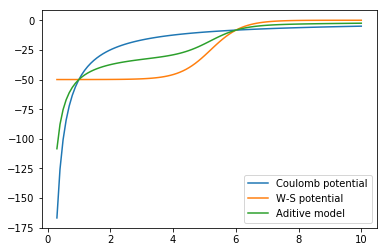

In [659]:
r_check_size = 100
r_range = [0.3, 10]
A = 72
r_check = np.linspace(start = r_range[0], stop = r_range[1], num = r_check_size)
V_r = WS_potential(r_check, A = A)
C_r = C_potential(r_check)
plt.plot(r_check, C_r, label = "Coulomb potential")
plt.plot(r_check, V_r, label = "W-S potential")
plt.plot(r_check, V_r * 0.5 + C_r * 0.5, label = "Aditive model")
plt.legend()
plt.show()

#### Experimental data

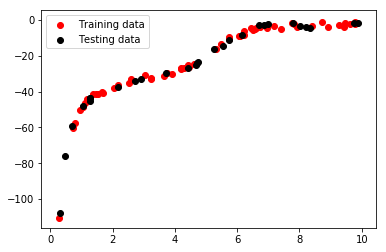

In [595]:
np.random.seed(0)
########### This sets up the simulation
# n_exp is the size of experimental data
# r_range is the range of r values we want to consider
# eps is the sd of experimental error
# A is the atomic mass number of the nuclei under consideration

n_exp = 84
r_range = [0.1, 10]
eps = 1 # Experimental eror
A = 72
############

r = r_exp(n_exp = n_exp, r_range = r_range, domain_type = 1)
y_exp = exp_data(r, eps, A = A)

# Train/test split
train_size = int(len(y_exp) * 2 / 3)
train_sample = np.random.choice(len(y_exp), train_size, replace=False)
test_sample = list(set(np.arange(len(y_exp))) - set(train_sample))


r_train = r[train_sample]
y_train = y_exp[train_sample]

r_test = r[test_sample]
y_test = y_exp[test_sample]


###### Sanity check
plt.scatter(r_train, y_train, c = 'r', label = "Training data")
plt.scatter(r_test, y_test, c = 'k', label = "Testing data")
plt.legend()
plt.show()
######

### WS Model - Evidence 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma]
100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:10<00:00, 1439.25it/s]
There were 3548 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


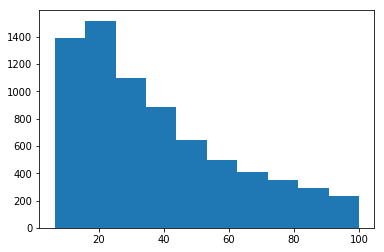

Integral calc: 100%|███████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1832.36it/s]


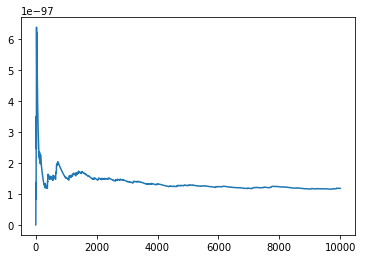

In [596]:
np.random.seed(0)
priors = {"sigma": [1, 30]}
n_mc = 10000
pm_model_WS, obs_WS, logp_WS = exp_model(r_train, y_train, priors, model_type = "WS", A = A)
mc_integral_WS = evidence_int(priors, pm_model_WS, obs_WS, logp_WS, n_mc)

### C Model - Evidence

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma]
100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:09<00:00, 1654.75it/s]
There were 3548 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


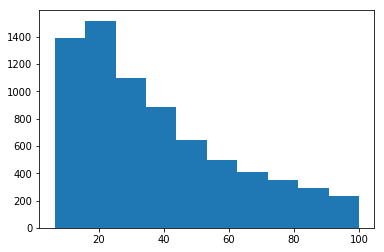

Integral calc: 100%|███████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1724.82it/s]


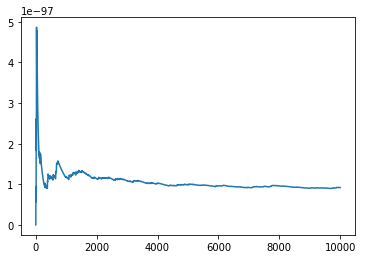

In [597]:
np.random.seed(0)
priors = {"sigma": [1, 30]}
n_mc = 10000
pm_model_C, obs_C, logp_C = exp_model(r_train, y_train, priors, model_type = "C", A = A)
mc_integral_C = evidence_int(priors, pm_model_C, obs_C, logp_C, n_mc)

In [598]:
mc_integral_C[-1] / mc_integral_WS[-1]

0.7781855715175818

### Predictions

In [599]:
# setup
n_pred = 20000
r_new = r
M1_M2_ratio = mc_integral_C[-1] / mc_integral_WS[-1]

#### WS Model - Prediction

In [600]:
np.random.seed(0)
pm_model_WS, obs_WS, logp_WS = exp_model(r, y_exp, priors, model_type = "WS", A = A)
predictions_WS, trace_WS = sample_predictions(r_new = r_new, pm_model = pm_model_WS, obs = obs_WS, model_type ="WS",
                                              n_pred = n_pred, A = A)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma]
100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:15<00:00, 331.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Posterior predictive distribution: 100%|████████████████████████████████████████| 20000/20000 [01:50<00:00, 180.22it/s]


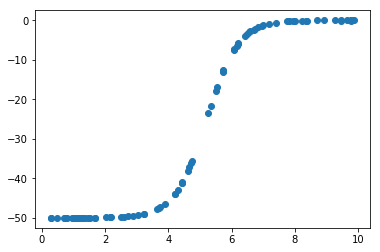

In [601]:
# Sanity check
plt.scatter(r_new, np.mean(predictions_WS, axis = 1))
plt.show()

#### C Model - Prediction

In [602]:
np.random.seed(0)
pm_model_C, obs_C, logp_C = exp_model(r, y_exp, priors, model_type = "C", A = A)
predictions_C, trace_C = sample_predictions(r_new = r_new, pm_model = pm_model_C, obs = obs_C, model_type ="C",
                                              n_pred = n_pred, A = A)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma]
100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:19<00:00, 316.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Posterior predictive distribution: 100%|█████████████████████████████████████████| 20000/20000 [01:57<00:00, 89.04it/s]


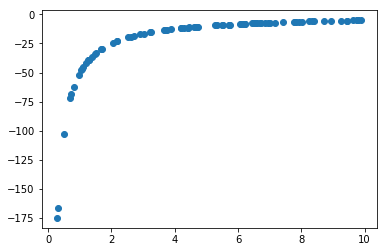

In [603]:
# Sanity check
plt.scatter(r_new, np.mean(predictions_C, axis = 1))
plt.show()

#### BMA - Predictions

In [604]:
predictions_BMA = sample_mixture(predictions_C, predictions_WS, M1_M2_ratio)

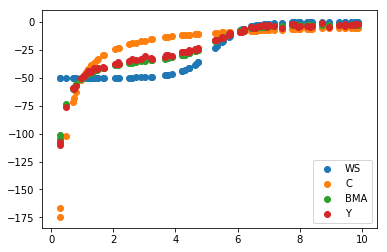

In [605]:
# Sanity check full data
plt.scatter(r_new, np.mean(predictions_WS, axis = 1), label = "WS")
plt.scatter(r_new, np.mean(predictions_C, axis = 1), label = "C")
plt.scatter(r_new, np.mean(predictions_BMA, axis = 1), label = "BMA")
#plt.scatter(r_new, np.mean(predictions_WS, axis = 1) * 0.5 + np.mean(predictions_C, axis = 1) * 0.5, label = "BMA_avg")
plt.scatter(r_new, y_exp, label = "Y")
plt.legend()
plt.show()

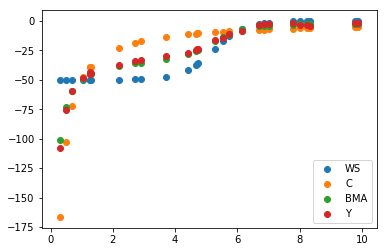

In [606]:
# Sanity check test data
plt.scatter(r_new[test_sample], np.mean(predictions_WS[test_sample,:], axis = 1), label = "WS")
plt.scatter(r_new[test_sample], np.mean(predictions_C[test_sample,:], axis = 1), label = "C")
plt.scatter(r_new[test_sample], np.mean(predictions_BMA[test_sample,:], axis = 1), label = "BMA")
plt.scatter(r_new[test_sample], y_exp[test_sample], label = "Y")
plt.legend()
plt.show()

In [607]:
print("RMSE BMA:" + str(np.sqrt(mse(y_exp[test_sample], predictions_BMA[test_sample,:]))))
print("RMSE W-S:" + str(np.sqrt(mse(y_exp[test_sample], predictions_WS[test_sample,:]))))
print("RMSE C:" + str(np.sqrt(mse(y_exp[test_sample], predictions_C[test_sample,:]))))
print("r^2: " + str(1 - mse(y_exp[test_sample], predictions_BMA[test_sample,:]) / np.min([mse(y_exp[test_sample], predictions_WS[test_sample,:]), mse(y_exp[test_sample], predictions_C[test_sample,:])])))

RMSE BMA:1.81571839476193
RMSE W-S:14.596832461306748
RMSE C:15.0703239716332
r^2: 0.984526814215902


In [608]:
print("RMSE BMA:" + str(np.sqrt(mse(y_exp, predictions_BMA))))
print("RMSE W-S:" + str(np.sqrt(mse(y_exp, predictions_WS))))
print("RMSE C:" + str(np.sqrt(mse(y_exp, predictions_C))))
print("r^2: " + str(1 - mse(y_exp, predictions_BMA) / np.min([mse(y_exp, predictions_WS), mse(y_exp, predictions_C)])))

RMSE BMA:1.77357486024002
RMSE W-S:13.142430380564297
RMSE C:13.357663436334754
r^2: 0.9817884178102888
